# figures_draft2018a.ipynb

## Purpose
Produce figures and supplementary figures for project p17d.

## Dependencies
Python modules mentioned in next cell, inlcuding [climapy](https://github.com/grandey/climapy) ([doi:10.5281/zenodo.1053020](https://doi.org/10.5281/zenodo.1053020)) and [lib_draft2018a.py](https://github.com/grandey/p17d-sulphur-eas-eqm/blob/master/analysis_draft2018a/lib_draft2018a.py) 

## Data requirements
- **Default MAM3 emissions data**, available from the CESM input data repository. The variable `mam3_emis_dir` in [lib_draft2018a.py](https://github.com/grandey/p17d-sulphur-eas-eqm/blob/master/analysis_draft2018a/lib_draft2018a.py) must point to the correct local folder.
- **Modified MAM3 emissions data**, available via https://doi.org/10.6084/m9.figshare.6072887. The variable `p17d_emis_dir` in [lib_draft2018a.py](https://github.com/grandey/p17d-sulphur-eas-eqm/blob/master/analysis_draft2018a/lib_draft2018a.py) must point to the correct local folder.
- **CESM output data**, post-processed to time-series format, available via https://doi.org/10.6084/m9.figshare.6072887. The variable `output_dir` in [lib_draft2018a.py](https://github.com/grandey/p17d-sulphur-eas-eqm/blob/master/analysis_draft2018a/lib_draft2018a.py) must point to the correct local folder.
- **Post-processed** NetCDF files (`*_ml??.nc`) produced by [cdo_nco_draft2018a.ipynb](https://github.com/grandey/p17d-sulphur-eas-eqm/blob/master/analysis_draft2018a/cdo_nco_draft2018a.ipynb).
- **G16 CESM output data**, available via https://doi.org/10.6084/m9.figshare.2067084. The variable `g16_dir` in [lib_draft2018a.py](https://github.com/grandey/p17d-sulphur-eas-eqm/blob/master/analysis_draft2018a/lib_draft2018a.py) must point to the correct local folder.

## Author
Benjamin S. Grandey, 2018

In [1]:
! date

import climapy
import lib_draft2018a
import ipywidgets
from IPython.display import display
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
import pandas as pd
from scipy import stats
import warnings
import xarray as xr

# Print versions of dependencies
for package in [climapy, np, pd, xr]:
    try:
        print('{}.__version__ = {}'.format(package.__name__, package.__version__))
    except AttributeError:
        pass
print('lib_draft2018a.py is using {}'.format(lib_draft2018a.dependency_versions()))

Wed Jul 18 18:40:51 +08 2018
climapy.__version__ = 0.1.0+b35937c
numpy.__version__ = 1.14.3
pandas.__version__ = 0.23.0
xarray.__version__ = 0.10.4
lib_draft2018a.py is using {'climapy': '0.1.0+b35937c', 'pandas': '0.23.0', 'xarray': '0.10.4'}


In [2]:
%matplotlib inline

plt.rcParams['figure.dpi'] = 40  # reduce resolution of inline figures

In [3]:
# Initialise counters to keep track of figure numbers
figure_counter = 1  # main manuscript
supp_figure_counter = 1  # supplementary figures
other_figure_counter = 1  # other figures (not included in manuscript)

In [4]:
# Load dictionaries etc from lib_draft2018a
region_bounds_dict = lib_draft2018a.load_region_bounds_dict()
region_long_dict = lib_draft2018a.load_region_long_dict()
scenario_name_dict = lib_draft2018a.load_scenario_name_dict()
variable_long_dict = lib_draft2018a.load_variable_long_dict()
variable_symbol_dict = lib_draft2018a.load_variable_symbol_dict()
variable_units_dict = lib_draft2018a.load_variable_units_dict()

In [5]:
# Longitude and latitude data used later
# Load sample data
sample_data = lib_draft2018a.load_output().isel(year=0)
# Set sample data equal to one - here, we are just interested in lat-lon info
sample_data[:] = 1.
# Shift longitudes
sample_data = climapy.xr_shift_lon(sample_data, lon_min=-29)
# Longitude and latitude data
lon = sample_data['lon']
lat = sample_data['lat']
# Lower bound for first longitude bin (important for map)
lon0 = (lon[0] - (lon[1]-lon[0])/2.0).values
# Pseudo-lower bound for first latitude bin (used for stretching imshow)
lat0 = (lat[0] - (lat[1]-lat[0])/2.0).values
print('lon0 = {}, lat0 = {}'.format(lon0, lat0))

lon0 = -28.75, lat0 = -90.94736842105263


## Function to produce emissions bar chart

In [6]:
def emissions_bars(species='so2tot',
                   title=None,
                   xlabel=r'Sulfur dioxide emissions, Tg(SO$_2$) year$^{-1}$',
                   xlim=None,
                   ylabel=True,
                   region='ESEAs',
                   map_inset=True,
                   ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # Dataframe to hold regional totals
    data_df = pd.DataFrame(columns=('scenario', 'scenario_name', 'regional_total'))
    # Loop over scenarios
    for scenario in ['2000', 'eas0b', 'eas0c']:
        # Load emissions
        if species == 'so2tot':
            data = (lib_draft2018a.load_emissions(species='so2', surf_or_elev='both',
                                                  scenario=scenario, season='annual') +
                    lib_draft2018a.load_emissions(species='so4_a1', surf_or_elev='both',
                                                  scenario=scenario, season='annual') +
                    lib_draft2018a.load_emissions(species='so4_a2', surf_or_elev='both',
                                                  scenario=scenario, season='annual'))
        else:
            data = lib_draft2018a.load_emissions(species=species, surf_or_elev='both',
                                                 scenario=scenario, season='annual')
        # Calculate regional total
        lon_bounds, lat_bounds = region_bounds_dict[region]
        data = climapy.xr_area_weighted_stat(data, stat='sum', lon_bounds=lon_bounds,
                                             lat_bounds=lat_bounds).values / 1e12
        # Append to data_df
        data_df = data_df.append({'scenario': scenario, 
                                  'scenario_name': scenario_name_dict[scenario],
                                  'regional_total': data},
                                  ignore_index=True)
    # Plot bars
    ax.barh(data_df.index, data_df['regional_total'], height=0.5,
            color=['0.5', 'g', 'b'])
    # Axes
    ax.set_yticks(data_df.index)
    ax.set_yticklabels(data_df['scenario_name'])
    plt.gca().invert_yaxis()
    if ylabel:
        ax.set_ylabel('Scenario', fontsize='large')
    if xlabel:
        ax.set_xlabel(xlabel, fontsize='large')
    if xlim:
        ax.set_xlim(xlim)
    # Annotate with values
    for i in data_df.index:
        text = '{:.1f}'.format(data_df.loc[i, 'regional_total'])
        ax.text(data_df.loc[i, 'regional_total'], i,
                text, verticalalignment='center',
                horizontalalignment='left')
    # Annotate with percentage change
    regional_totals = data_df['regional_total']
    change = regional_totals[2] - regional_totals[0]
    perc_change = (change / regional_totals[0]) * 100
    if regional_totals[1] != regional_totals[0]:
        ypos = 0.4  # position of arrow
    else:
        ypos = 1.4
    ax.arrow(x=regional_totals[0], dx=change, y=ypos, dy=0,
             fc='r', ec='r',
             head_width=0.1, head_length=abs(change)/8,
             length_includes_head=True)
    ax.text(regional_totals[0]+change/2, ypos+0.1,
            '{:+.1f}%'.format(perc_change),
            color='red', horizontalalignment='center',
            verticalalignment='top')
    # Title
    if title:
        ax.set_title(title)
    # Insert map
    if map_inset:
        ax2 = inset_axes(ax, width='30%', height='60%', loc=4)
        ax2.set_facecolor('lightsteelblue')
        anchor = 'SE'
        if region == 'Globe':
            lon_bounds = [lon0, lon0+360.]
            lat_bounds = [-90.0, 90.0]
        else:
            lon_bounds, lat_bounds = region_bounds_dict[region]
        bm = Basemap(llcrnrlat=lat_bounds[0], urcrnrlat=lat_bounds[1],
                     llcrnrlon=lon_bounds[0], urcrnrlon=lon_bounds[1],
                     anchor=anchor)
        bm.drawcoastlines(color='0.5')
        bm.fillcontinents(color='white')
    return ax

# Examples
if False:
    emissions_bars()

## Emissions bar chart composite figure - Figure 1

/Users/grandey/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Written local/f01.pdf


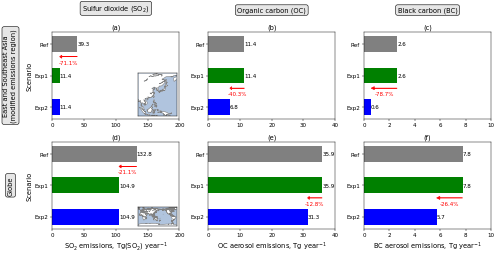

In [7]:
# Set up figure
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 3)
# Sulfur dioxide bar charts
species = 'so2tot'
xlabel = r'SO$_2$ emissions, Tg(SO$_2$) year$^{-1}$'
xlim = [0, 200]
ax1 = emissions_bars(species=species, title='(a)',
                     xlabel=None, xlim=xlim, ylabel=True,
                     region='ESEAs', map_inset=True,
                     ax=plt.subplot(gs[0, 0]))
ax2 = emissions_bars(species=species, title='(d)',
                     xlabel=xlabel, xlim=xlim, ylabel=True,
                     region='Globe', map_inset=True,
                     ax=plt.subplot(gs[1, 0]))
# Organic carbon bar charts
species = 'oc'
xlabel = r'OC aerosol emissions, Tg year$^{-1}$'
xlim = [0, 40]
ax3 = emissions_bars(species=species, title='(b)',
                     xlabel=None, xlim=xlim, ylabel=False,
                     region='ESEAs', map_inset=False,
                     ax=plt.subplot(gs[0, 1]))
ax4 = emissions_bars(species=species, title='(e)',
                     xlabel=xlabel, xlim=xlim, ylabel=False,
                     region='Globe', map_inset=False,
                     ax=plt.subplot(gs[1, 1]))
# Black carbon bar charts
species = 'bc'
xlabel = r'BC aerosol emissions, Tg year$^{-1}$'
xlim = [0, 10]
ax5 = emissions_bars(species=species, title='(c)',
                     xlabel=None, xlim=xlim, ylabel=False,
                     region='ESEAs', map_inset=False,
                     ax=plt.subplot(gs[0, 2]))
ax6 = emissions_bars(species=species, title='(f)',
                     xlabel=xlabel, xlim=xlim, ylabel=False,
                     region='Globe', map_inset=False,
                     ax=plt.subplot(gs[1, 2]))
# Column titles
for ax, title in zip([ax1, ax3, ax5],
                     [r'Sulfur dioxide (SO$_2$)',
                      r'Organic carbon (OC)',
                      r'Black carbon (BC)']):
    ax.text(0.5, 1.22, title,
            transform=ax.transAxes, fontsize='large',
            verticalalignment='bottom', horizontalalignment='center',
            bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Row titles
for ax, title in zip([ax1, ax2],
                     ['East and Southeast Asia\n(modified emissions region)',
                      'Globe']):
    ax.text(-0.33, 0.5, title,
            transform=ax.transAxes, fontsize='large', rotation=90,
            verticalalignment='center', horizontalalignment='center',
            bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Prevent overlapping labels
fig.tight_layout()
# Save figure
ofilename = 'local/f{:02}.pdf'.format(figure_counter)
fig.savefig(ofilename, bbox_inches='tight', dpi=300)
print('Written {}'.format(ofilename))
figure_counter += 1

## Function to produce zonal mean line plot of differences

In [8]:
def zonal_mean_line_plot(variable='PRECC+PRECL',
                         f_or_b='b',
                         xlabel=None,
                         xlim=None,
                         ylabel=None,
                         mean_format='${:+.2f}\pm{:.2f}$',
                         title=None,
                         ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # Loop over scenario combinations
    if f_or_b == 'b':
        scenario_list = ['R45', 'eas0b', 'eas0c']
        ref_scenario_list = ['A2x', '2000', '2000']
    else:
        scenario_list = ['pR45', 'eas0b', 'eas0c']
        ref_scenario_list = ['pA2x', '2000', '2000']
    for scenario, ref_scenario, c, linestyle in zip(scenario_list,
                                                    ref_scenario_list,
                                                    ['r', 'g', 'b'],
                                                    [':', '--', '-']):
        # Load data
        data = lib_draft2018a.load_output(variable=variable, scenario=scenario,
                                          f_or_b=f_or_b,
                                          season='annual', apply_sf=True)
        zm = data.mean(dim='lon')
        awm = climapy.xr_area_weighted_stat(data)
        data.close()
        # Load data for reference scenario
        ref_data = lib_draft2018a.load_output(variable=variable, scenario=ref_scenario,
                                          f_or_b=f_or_b,
                                          season='annual', apply_sf=True)
        ref_zm = ref_data.mean(dim='lon')  # zonal mean
        ref_awm = climapy.xr_area_weighted_stat(ref_data)  # area-weighted means
        ref_data.close()
        # Area-weighted mean diff and error - used for legend label
        awm_diff = (ref_awm.mean(dim='year').data -
                    awm.mean(dim='year').data)
        error1 = (ref_awm.std(dim='year', ddof=1).data.flatten() /
                  np.sqrt(ref_awm['year'].size))
        error2 = (awm.std(dim='year', ddof=1).data.flatten() /
                  np.sqrt(awm['year'].size))
        error = float(np.sqrt(error1**2 + error2**2))
        # Legend label
        label = ('{}$-${}\n'.format(scenario_name_dict[ref_scenario],
                                    scenario_name_dict[scenario]) +
                 mean_format.format(awm_diff, error))
        # Print area-weighted mean to reduced precision for quoting in manuscript
        if mean_format == '${:+.2f}\pm{:.2f}$':
            reduced_precision_format = '{:+.1f}±{:.1f}'
        else:
            reduced_precision_format = '{:+.2f}±{:.2f}'
        print('{}-{} mean = '.format(scenario_name_dict[ref_scenario],
                                     scenario_name_dict[scenario]) +
              reduced_precision_format.format(awm_diff, error))
        # Plot line - showing mean diff across time
        diff = (ref_zm.mean(dim='year').data.flatten()  # Ref - scenario
                - zm.mean(dim='year').data.flatten())
        ax.plot(diff, zm['lat'].data,
                c=c, linestyle=linestyle, alpha=1,
                label=label)
        # Plot shading - showing standard error
        error1 = (ref_zm.std(dim='year', ddof=1).data.flatten() /
                  np.sqrt(ref_zm['year'].size))
        error2 = (zm.std(dim='year', ddof=1).data.flatten() /
                  np.sqrt(zm['year'].size))
        error = np.sqrt(error1**2 + error2**2)
        ax.fill_betweenx(zm['lat'].data, diff-error, diff+error,
                         facecolor=c, alpha=0.2)
    # Lines showing zero
    ax.axhline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    ax.axvline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    # y-axis
    plt.yticks(fontsize='large')
    ax.set_ylim([-90, 90])
    ax.set_yticks(np.arange(-90, 91, 30))
    if ylabel:
        ax.set_ylabel(r'Latitude, $^\circ$N', fontsize='x-large')
    # x-axis
    plt.xticks(fontsize='large')
    if xlabel:
        ax.set_xlabel(xlabel, fontsize='x-large')
    if xlim:
        ax.set_xlim(xlim)
    # Title and legend
    if title:
        ax.set_title(title, fontsize='x-large')
    ax.legend(loc=4, labelspacing=2)
    return ax

# Example
if False:
    zonal_mean_line_plot()

## Function to produce maps of differences

In [9]:
def difference_map(variable='TS',
                   f_or_b='b',
                   ref_scenario='2000', scenario='eas0c',
                   vlim=[-1.2, 1.2], whiteout='0.05',
                   cmap_name='RdBu_r', nlev=12, colorbar=True,
                   mean_format='Mean$={:+.3f}\pm{:.3f}$',
                   title=None,
                   ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # Discretise colormap and set over/under
    cmap = plt.cm.get_cmap(cmap_name, nlev)
    if cmap_name == 'RdBu_r':
        cmap.set_under([0, 0, 0.25])
        cmap.set_over([0.25, 0, 0])
    elif cmap_name=='BrBG':
        cmap.set_under([0.2,0.1,0])
        cmap.set_over([0,0.15,0.1])
    # Load data for scenario
    data = lib_draft2018a.load_output(variable=variable,
                                      scenario=scenario,
                                      f_or_b=f_or_b,
                                      season='annual',
                                      apply_sf=True)
    data = climapy.xr_shift_lon(data, lon_min=-29.)  # shift longitudes
    # Load data for reference scenario
    ref_data = lib_draft2018a.load_output(variable=variable,
                                          scenario=ref_scenario,
                                          f_or_b=f_or_b,
                                          season='annual',
                                          apply_sf=True)
    ref_data = climapy.xr_shift_lon(ref_data, lon_min=-29.)  # shift longitudes
    # Calculate means across time
    tm = data.mean(dim='year').data
    ref_tm = ref_data.mean(dim='year').data
    tm_diff = ref_tm - tm  # difference, Ref - scenario
    # Find where statistically significant and larger than whiteout value
    p_values = stats.ttest_ind(data.data,
                               ref_data.data,
                               equal_var=True)[1]  # two sample t-test
    if np.isnan(p_values).any():  # check for NaNs in p_values and replace with ones...
        w_replace = (np.where(np.isnan(p_values) &
                              (tm_diff == 0.)))  #... if tm_diff is zero
        p_values[w_replace] = 1.
    p_fdr = climapy.stats_fdr(p_values,
                              alpha=0.05)  # p-value threshold for alpha=0.05
    w_sig = np.where((p_values.ravel() <= p_fdr) &  # statistically significant &
                     (np.abs(tm_diff.ravel()) >  # larger than whiteout value
                      float(whiteout)))
    lon_sig, lat_sig = np.meshgrid(data['lon'].data, data['lat'].data)
    lon_sig = lon_sig.ravel()[w_sig]
    lat_sig = lat_sig.ravel()[w_sig]
    # Map
    bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0,
                 llcrnrlon=lon0, urcrnrlon=360.0+lon0, ax=ax)
    bm.drawcoastlines(ax=ax)
    # Plot field and stippling
    tm_diff_masked = np.ma.masked_inside(tm_diff, -1*float(whiteout),
                                         float(whiteout))
    im = ax.imshow(tm_diff_masked,
                   extent=[lon0, 360+lon0, -lat0, lat0],
                   vmin=vlim[0], vmax=vlim[1], cmap=cmap, aspect='auto')
    ax.scatter(lon_sig, lat_sig, marker='.', s=0.05, c='k')
    # Annotate with p-value threshold
    ax.text(lon0, -105, r'$p_{{FDR}}\approx{:.3f}$'.format(p_fdr),
            color='0.5', horizontalalignment='left', verticalalignment='center',
            fontsize='large')
    # Annotate with area-weighted mean
    mean_list = []  # list to hold area-weighted means
    error_list = []  # list to hold standard errors on means
    for d in [ref_data, data]:
        awm = climapy.xr_area_weighted_stat(d)
        mean_list.append(awm.mean(dim='year').data)
        error = (awm.std(dim='year', ddof=1).data.flatten() /
                 np.sqrt(awm['year'].size))
        error_list.append(error)
    mean_diff = mean_list[0] - mean_list[1]
    error = float(np.sqrt(error_list[0]**2 + error_list[1]**2))  # combine errors
    ax.text(lon0+360, -105, 'Mean = '+mean_format.format(mean_diff, error),
            color='k', horizontalalignment='right', verticalalignment='center',
            fontsize='large')
    # Colorbar
    if colorbar:
        if tm_diff.min() < vlim[0] and tm_diff.max() > vlim[1]:
            extend = 'both'
        elif tm_diff.min() < vlim[0]:
            extend = 'min'
        elif tm_diff.max() > vlim[1]:
            extend = 'max'
        else:
            extend = 'neither'
        ticks = np.arange(vlim[0], vlim[1]+1e-10, (vlim[1]-vlim[0])/(nlev/2))
        cbar = plt.colorbar(im, ticks=ticks, extend=extend)
        if float(whiteout) != 0:
            tick_labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
            tick_labels[int(nlev/4)] = r'$\pm$' + whiteout
            cbar.ax.set_yticklabels(tick_labels, fontsize='large')
        label = '{}, {}'.format(variable_symbol_dict[variable],
                                variable_units_dict[variable])
        cbar.set_label(label, fontsize='x-large', labelpad=7)
    # Close datasets
    for d in [ref_data, data]:
        d.close()
    # Title
    if title:
        ax.set_title(title, fontsize='x-large')
    return ax, im, tm_diff
                     
# Examples
if False:
    # Example 1
    ax, im, tm_diff = difference_map()
    # Example 2
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])
    variable = 'TS'
    f_or_b='b'
    xlabel = '{}, {}'.format(variable_symbol_dict[variable],
                             variable_units_dict[variable])
    xlim = [-1.2, 1.2]
    mean_format='${:+.3f}\pm{:.3f}$'
    title = '(a) {} ({})'.format(variable_long_dict[variable],
                                 variable_symbol_dict[variable])
    ax = zonal_mean_line_plot(variable=variable, f_or_b=f_or_b,
                              xlabel=xlabel, xlim=xlim,
                              ylabel=True, mean_format=mean_format,
                              title=title,
                              ax=plt.subplot(gs[0, 0]))
    nlev = 12
    whiteout = '0.05'
    ax, im, tm_diff = difference_map(variable=variable, f_or_b=f_or_b,
                                     ref_scenario='2000', scenario='eas0c',
                                     vlim=xlim, whiteout=whiteout,
                                     cmap_name='RdBu_r', nlev=nlev, colorbar=True,
                                     mean_format=mean_format,
                                     title='(b) Ref$-$Exp2',
                                     ax=plt.subplot(gs[0, 1]))
    fig.tight_layout()

## Function to produce composite of (a) zonal mean and (b) Ref-Exp2 map

In [10]:
def zonal_mean_exp2_map(variable='TS', f_or_b='b',
                        xlim=[-0.8, 1.0],
                        vlim=[-1.2, 1.2], whiteout='0.05',
                        cmap_name='RdBu_r', nlev=12,
                        mean_format='${:+.3f}\pm{:.3f}$',
                        file_prefix=None):
    # Set-up figure
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])
    # (a) Zonal mean
    xlabel = '{}, {}'.format(variable_symbol_dict[variable],
                             variable_units_dict[variable])
    title = '(a) Zonal mean differences'
    ax = zonal_mean_line_plot(variable=variable, f_or_b=f_or_b,
                              xlabel=xlabel, xlim=xlim,
                              ylabel=True, mean_format=mean_format,
                              title=title,
                              ax=plt.subplot(gs[0, 0]))
    # (b) Ref - Exp2 map
    ax, im, tm_diff = difference_map(variable=variable, f_or_b=f_or_b,
                                     ref_scenario='2000', scenario='eas0c',
                                     vlim=vlim, whiteout=whiteout,
                                     cmap_name=cmap_name, nlev=nlev, colorbar=True,
                                     mean_format=mean_format,
                                     title='(b) Ref$-$Exp2',
                                     ax=plt.subplot(gs[0, 1]))
    # Prevent overlapping labels
    fig.tight_layout()
    # Save
    if file_prefix:
        fig.savefig('local/{}.pdf'.format(file_prefix), bbox_inches='tight', dpi=300)
        print('Written local/{}.pdf'.format(file_prefix))
    return fig
    
# Examples 
if False:
    zonal_mean_exp2_map(file_prefix='temp')

## Function to produce regional Hovmuller difference plot

In [11]:
def hovmuller_diff(variable='PRECC+PRECL',
                   f_or_b='b',
                   ref_scenario='2000', exp_scenario='eas0c',
                   region='EAs',
                   vlim=[-1.2, 1.2], whiteout='0.05',
                   cmap_name='BrBG', nlev=12,
                   colorbar=True, cax=None,
                   ylim=[5, 50], ylabel=True, xlabel=True,
                   title=None,
                   ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # Discretise colormap and set over/under
    cmap = plt.cm.get_cmap(cmap_name, nlev)
    if cmap_name == 'RdBu_r':
        cmap.set_under([0, 0, 0.25])
        cmap.set_over([0.25, 0, 0])
    elif cmap_name=='BrBG':
        cmap.set_under([0.2,0.1,0])
        cmap.set_over([0,0.15,0.1])
    # Load data for reference scenario
    ref_mayx = lib_draft2018a.load_output_monthly(variable=variable,
                                                  scenario=ref_scenario,
                                                  f_or_b=f_or_b,
                                                  apply_sf=True)
    if 'lev' in ref_mayx.dims:  # check for lev dimension
        if ref_mayx['lev'].size == 1:
            ref_mayx = ref_mayx.mean(dim='lev')  # remove lev dimension
    # Load data for experimental scenario
    exp_mayx = lib_draft2018a.load_output_monthly(variable=variable,
                                                  scenario=exp_scenario,
                                                  f_or_b=f_or_b,
                                                  apply_sf=True)
    if 'lev' in exp_mayx.dims:  # check for lev dimension
        if exp_mayx['lev'].size == 1:
            exp_mayx = exp_mayx.mean(dim='lev')  # remove lev dimension
    # If units are per year, change to per day
    units = variable_units_dict[variable]
    if 'year$^{-1}$' in units:
        units = units.replace('year$^{-1}$', 'day$^{-1}$')
        ref_mayx = ref_mayx / 365
        exp_mayx = exp_mayx / 365
    # Select longitude range of interest
    ref_mayx = climapy.xr_shift_lon(ref_mayx, lon_min=-29.)  # shift longitudes
    exp_mayx = climapy.xr_shift_lon(exp_mayx, lon_min=-29.)  # shift longitudes
    lon_bounds = region_bounds_dict[region][0]
    ref_mayx = climapy.xr_mask_bounds(ref_mayx, lon_bounds=lon_bounds,
                                      lat_bounds=ylim)
    exp_mayx = climapy.xr_mask_bounds(exp_mayx, lon_bounds=lon_bounds,
                                      lat_bounds=ylim)
    ref_mayx = ref_mayx.dropna(dim='lon', how='all').dropna(dim='lat', how='all')
    exp_mayx = exp_mayx.dropna(dim='lon', how='all').dropna(dim='lat', how='all')
    # Average across longitudes
    ref_may = ref_mayx.mean(dim='lon')
    exp_may = exp_mayx.mean(dim='lon')
    # Mean across years and difference (Ref-Exp)
    ref_my = ref_may.mean(dim='year')
    exp_my = exp_may.mean(dim='year')
    diff_my = ref_my - exp_my
    # Latitude extent
    dlat = ref_my['lat'][1] - ref_my['lat'][0]
    lat_extent = [(ref_my['lat'][0] - dlat/2.0).values,
                  (ref_my['lat'][-1] + dlat/2.0).values]
    # Plot image
    im = ax.imshow(np.flipud(np.ma.masked_inside(diff_my.T.data,
                                                  -float(whiteout),
                                                  float(whiteout))),
                   extent=[0.5, 12.5, lat_extent[0], lat_extent[1]],
                   aspect='auto',
                   interpolation='Nearest',
                   vmin=vlim[0], vmax=vlim[1], cmap=cmap)
    # Find where statistically significant and larger than whiteout value
    p_values = stats.ttest_ind(ref_may.data,
                               exp_may.data,
                               axis=1,
                               equal_var=True)[1]  # Two sample t-test
    if np.isnan(p_values).any():  # check for NaNs in p_values and replace with ones...
        w_replace = (np.where(np.isnan(p_values) &
                             (diff_my == 0.)))  #... if diff_my is zero
        p_values[w_replace] = 1.
    p_fdr = climapy.stats_fdr(p_values,
                              alpha=0.05)  # p-value threshold for alpha=0.05
    w_sig = np.where((p_values.ravel() <= p_fdr) &  # statistically significant &
                     (np.abs(diff_my.data.ravel()) >  # larger than whiteout value
                      float(whiteout)))
    lat_sig, month_sig = np.meshgrid(diff_my['lat'].data, diff_my['month'].data)
    lat_sig = lat_sig.ravel()[w_sig]
    month_sig = month_sig.ravel()[w_sig]
    # Plot stippling
    ax.scatter(month_sig, lat_sig, marker='x', s=20, c='k', linewidth=None)
    ax.scatter(month_sig, lat_sig, marker='.', s=10, c='w', linewidth=0)
    # Annotate with p-value threshold
    ax.text(12.7, ylim[0], r'$p_{{FDR}}\approx{:.3f}$'.format(p_fdr),
            color='0.5', rotation='90',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize='large')
    # Lines to show region latitude bounds
    for lat_bound in region_bounds_dict[region][1]:
        ax.axhline(lat_bound, c='purple', linewidth=1, linestyle='--')
    # y-axis
    ax.set_ylim(ylim)
    plt.yticks(np.arange(ylim[0], ylim[1]+1, 5),
               fontsize='large')
    if ylabel:
        ax.set_ylabel(r'Latitude, $^\circ$N', fontsize='x-large')
    # x-axis
    plt.xticks(range(1, 13),
               ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'],
               fontsize='large')
    if xlabel:
        ax.set_xlabel('Month', fontsize='x-large')
    # Colorbar
    if colorbar:
        # Invert colorbar?
        if vlim[0] > vlim[1]:
            vlim = vlim[::-1]
            invert_colorbar = True
        else:
            invert_colorbar = False
        # Extend?    
        if diff_my.min() < vlim[0] and diff_my.max() > vlim[1]:
            extend = 'both'
        elif diff_my.min() < vlim[0]:
            extend = 'min'
        elif diff_my.max() > vlim[1]:
            extend = 'max'
        else:
            extend = 'neither'
        # Ticks and labels
        ticks = np.arange(vlim[0], vlim[1]+1e-10, (vlim[1]-vlim[0])/(nlev/2))
        cbar = plt.colorbar(im, cax=cax, ticks=ticks, extend=extend,
                            orientation='horizontal')
        tick_labels = [item.get_text() for item in cbar.ax.get_xticklabels()]
        if float(whiteout) != 0:
            tick_labels[int(nlev/4)] = r'$\pm$' + whiteout
        cbar.ax.set_xticklabels(tick_labels, fontsize='large')
        label = '{}, {}'.format(variable_symbol_dict[variable], units)
        cbar.set_label(label, fontsize='x-large', labelpad=7)
        # Invert colorbar?
        if invert_colorbar:
            cbar.ax.invert_xaxis()
    # Title
    if title:
        ax.set_title(title, fontsize='x-large')
    return ax, im, diff_my

if False:
    hovmuller_diff()

## Function to produce regional Hovmuller plot for a single scenario

In [12]:
def hovmuller_scenario(variable='PRECC+PRECL',
                       f_or_b='b',
                       scenario='2000',
                       region='EAs',
                       vlim=[0, 12], whiteout='0.0',
                       cmap_name='jet', nlev=12,
                       colorbar=True, cax=None,
                       ylim=[5, 50], ylabel=True, xlabel=True,
                       title=None,
                       ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # Discretise colormap and set over/under
    cmap = plt.cm.get_cmap(cmap_name, nlev)
    if cmap_name == 'RdBu_r':
        cmap.set_under([0, 0, 0.25])
        cmap.set_over([0.25, 0, 0])
    elif cmap_name=='BrBG':
        cmap.set_under([0.2,0.1,0])
        cmap.set_over([0,0.15,0.1])
    # Load data for scenario
    data_mayx = lib_draft2018a.load_output_monthly(variable=variable,
                                                   scenario=scenario,
                                                   f_or_b=f_or_b,
                                                   apply_sf=True)
    if 'lev' in data_mayx.dims:  # check for lev dimension
        if data_mayx['lev'].size == 1:
            data_mayx = data_mayx.mean(dim='lev')  # remove lev dimension
    # If units are per year, change to per day
    units = variable_units_dict[variable]
    if 'year$^{-1}$' in units:
        units = units.replace('year$^{-1}$', 'day$^{-1}$')
        data_mayx = data_mayx / 365
    # Select longitude range of interest
    data_mayx = climapy.xr_shift_lon(data_mayx, lon_min=-29.)  # shift longitudes
    lon_bounds = region_bounds_dict[region][0]
    data_mayx = climapy.xr_mask_bounds(data_mayx, lon_bounds=lon_bounds,
                                       lat_bounds=ylim)
    data_mayx = data_mayx.dropna(dim='lon', how='all').dropna(dim='lat', how='all')
    # Average across longitudes
    data_may = data_mayx.mean(dim='lon')
    # Mean across years
    data_my = data_may.mean(dim='year')
    # Latitude extent
    dlat = data_my['lat'][1] - data_my['lat'][0]
    lat_extent = [(data_my['lat'][0] - dlat/2.0).values,
                  (data_my['lat'][-1] + dlat/2.0).values]
    # Plot image
    im = ax.imshow(np.flipud(np.ma.masked_inside(data_my.T.data,
                                                 -float(whiteout),
                                                 float(whiteout))),
                   extent=[0.5, 12.5, lat_extent[0], lat_extent[1]],
                   aspect='auto',
                   interpolation='Nearest',
                   vmin=vlim[0], vmax=vlim[1], cmap=cmap)
    # Lines to show region latitude bounds
    for lat_bound in region_bounds_dict[region][1]:
        ax.axhline(lat_bound, c='purple', linewidth=1, linestyle='--')
    # y-axis
    ax.set_ylim(ylim)
    plt.yticks(np.arange(ylim[0], ylim[1]+1, 5),
               fontsize='large')
    if ylabel:
        ax.set_ylabel(r'Latitude, $^\circ$N', fontsize='x-large')
    # x-axis
    plt.xticks(range(1, 13),
               ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'],
               fontsize='large')
    ax.set_xlim([0.5, 12.5])
    if xlabel:
        ax.set_xlabel('Month', fontsize='x-large')
    # Colorbar
    if colorbar:
        # Invert colorbar?
        if vlim[0] > vlim[1]:
            vlim = vlim[::-1]
            invert_colorbar = True
        else:
            invert_colorbar = False
        # Extend?
        if data_my.min() < vlim[0] and data_my.max() > vlim[1]:
            extend = 'both'
        elif data_my.min() < vlim[0]:
            extend = 'min'
        elif data_my.max() > vlim[1]:
            extend = 'max'
        else:
            extend = 'neither'
        # Ticks and labels
        ticks = np.arange(vlim[0], vlim[1]+1e-10, (vlim[1]-vlim[0])/(nlev/2))
        cbar = plt.colorbar(im, cax=cax, ticks=ticks, extend=extend,
                            orientation='horizontal')
        tick_labels = [item.get_text() for item in cbar.ax.get_xticklabels()]
        if float(whiteout) != 0:
            tick_labels[int(nlev/4)] = r'$\pm$' + whiteout
        cbar.ax.set_xticklabels(tick_labels, fontsize='large')
        label = '{}, {}'.format(variable_symbol_dict[variable].replace('\Delta ', ''),
                                units)
        cbar.set_label(label, fontsize='x-large', labelpad=7)
        # Invert colorbar?
        if invert_colorbar:
            cbar.ax.invert_xaxis()
    # Title
    if title:
        ax.set_title(title, fontsize='x-large')
    return ax, im, data_my

if False:
    hovmuller_scenario()

## Function to create Hovmuller composite of Ref and Exp2-Ref

In [13]:
def hovmuller_ref_diff(variable='PRECC+PRECL',
                       f_or_b='b',
                       region='EAs',
                       ref_vlim=[0, 12], ref_whiteout='0.0',
                       ref_cmap_name='jet', ref_nlev=12,
                       diff_vlim=[-1.2, 1.2], diff_whiteout='0.05',
                       diff_cmap_name='BrBG', diff_nlev=12,
                       ylim=[5, 50],
                       file_prefix=None):
    # Set-up figure
    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(2, 3,  # 2nd column for map; 2nd row for colorbars
                           height_ratios=[1, 0.1], width_ratios=[3, 1, 3])
    # 1st column: Ref
    ax1, im, diff_my = hovmuller_scenario(variable=variable,
                                          f_or_b=f_or_b,
                                          scenario='2000',
                                          region=region,
                                          vlim=ref_vlim, whiteout=ref_whiteout,
                                          cmap_name=ref_cmap_name, nlev=ref_nlev,
                                          colorbar=True,
                                          cax=plt.subplot(gs[1, 0]),
                                          ylim=ylim, ylabel=True, xlabel=True,
                                          title='(a) Ref',
                                          ax=plt.subplot(gs[0, 0]))
    # 2nd column: map
    ax2 = plt.subplot(gs[0, 1], sharey=ax1)
    ax2.set_facecolor('lightsteelblue')
    lon_bounds = region_bounds_dict[region][0]
    bm = Basemap(llcrnrlat=ylim[0], urcrnrlat=ylim[1],
                 llcrnrlon=lon_bounds[0], urcrnrlon=lon_bounds[1],
                 fix_aspect=False)
    bm.drawcoastlines(color='0.5')
    bm.fillcontinents(color='white')
    plt.xticks(lon_bounds, fontsize='large')
    plt.yticks(ylim, fontsize='large')
    # Map: lines to show region latitude bounds
    for lat_bound in region_bounds_dict[region][1]:
        ax2.axhline(lat_bound, c='purple', linewidth=1, linestyle='--')
    # Map: label region
    region_text = '\n'.join(region_long_dict[region].split())
    ax2.text(np.mean(lon_bounds), np.mean(region_bounds_dict[region][1]),
             region_text,
             fontsize='x-large', fontweight='bold',
             horizontalalignment='center', verticalalignment='center')
    # Map: title for map
    if lon_bounds[0] > 0:
        title_text = '{:.0f}–{:.0f}$^\circ$E'.format(
                lon_bounds[0], lon_bounds[1])
    elif lon_bounds[1] < 0:
        title_text = '{:.0f}–{:.0f}$^\circ$W'.format(
                -lon_bounds[0], -lon_bounds[1])
    else:
        title_text = '{:.0f}$^\circ$W–{:.0f}$^\circ$E'.format(
                -lon_bounds[0], lon_bounds[1])
    ax2.set_title(title_text, fontsize='x-large')
    # 3rd column: Ref-Exp2
    ax3, im, data_my = hovmuller_diff(variable=variable,
                                      f_or_b=f_or_b,
                                      ref_scenario='2000',
                                      exp_scenario='eas0c',
                                      region=region,
                                      vlim=diff_vlim, whiteout=diff_whiteout,
                                      cmap_name=diff_cmap_name, nlev=diff_nlev,
                                      colorbar=True,
                                      cax=plt.subplot(gs[1, 2]),
                                      ylim=ylim, ylabel=False, xlabel=True,
                                      title='(b) Ref$-$Exp2',
                                      ax=plt.subplot(gs[0, 2], sharey=ax1))
    # Prevent overlapping labels
    fig.tight_layout()
    # Save
    if file_prefix:
        fig.savefig('local/{}.pdf'.format(file_prefix), bbox_inches='tight', dpi=300)
        print('Written local/{}.pdf'.format(file_prefix))
    return fig
    
# Examples 
if False:
    hovmuller_ref_diff(file_prefix='temp')

## Apply functions above to produce figures
Note: Figure 1 is produced above, in cell 7.

In [14]:
plt.rcParams['axes.titlepad'] = 15  # increase distance to title

pA2x-pRCP4.5 mean = -0.39±0.06
Ref-Exp1 mean = -0.24±0.04
Ref-Exp2 mean = -0.49±0.04
Written local/f02.pdf


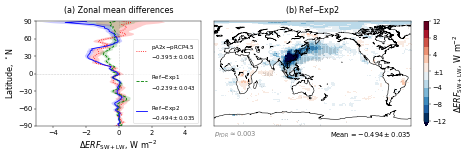

In [15]:
# Net ERF
zonal_mean_exp2_map(variable='FSNTOA+LWCF', f_or_b='f',
                    xlim=[-5, 5],
                    vlim=[-12, 12], whiteout='1',
                    cmap_name='RdBu_r', nlev=12,
                    mean_format='${:+.3f}\pm{:.3f}$',
                    file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

pA2x-pRCP4.5 mean = -0.98±0.06
Ref-Exp1 mean = -0.44±0.04
Ref-Exp2 mean = -0.66±0.03
Written local/fS01.pdf


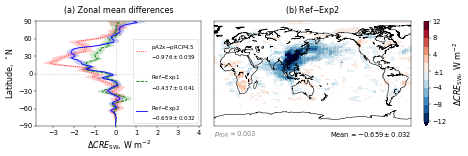

In [16]:
# CRE SW
zonal_mean_exp2_map(variable='SWCF_d1', f_or_b='f',
                    xlim=[-3.8, 4.1],
                    vlim=[-12, 12], whiteout='1',
                    cmap_name='RdBu_r', nlev=12,
                    mean_format='${:+.3f}\pm{:.3f}$',
                    file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

pA2x-pRCP4.5 mean = +0.49±0.03
Ref-Exp1 mean = +0.26±0.02
Ref-Exp2 mean = +0.18±0.02
Written local/fS02.pdf


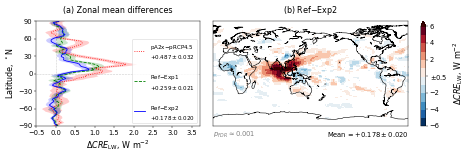

In [17]:
# CRE LW
zonal_mean_exp2_map(variable='LWCF', f_or_b='f',
                    xlim=[-0.5, 3.7],
                    vlim=[-6, 6], whiteout='0.5',
                    cmap_name='RdBu_r', nlev=12,
                    mean_format='${:+.3f}\pm{:.3f}$',
                    file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

pA2x-pRCP4.5 mean = +0.06±0.01
Ref-Exp1 mean = -0.03±0.01
Ref-Exp2 mean = +0.03±0.01
Written local/fS03.pdf


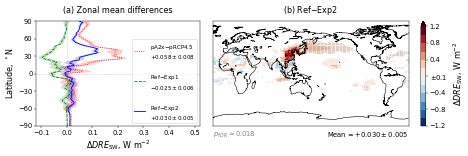

In [18]:
# DRE
zonal_mean_exp2_map(variable='FSNTOA-FSNTOA_d1', f_or_b='f',
                    xlim=[-0.12, 0.52], 
                    vlim=[-1.2, 1.2], whiteout='0.1',
                    cmap_name='RdBu_r', nlev=12,
                    mean_format='${:+.3f}\pm{:.3f}$',
                    file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

pA2x-pRCP4.5 mean = +0.04±0.03
Ref-Exp1 mean = -0.04±0.02
Ref-Exp2 mean = -0.04±0.02
Written local/fS04.pdf


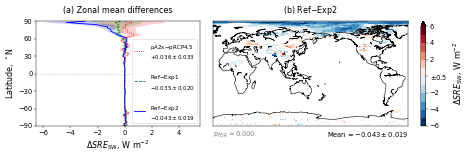

In [19]:
# SRE
zonal_mean_exp2_map(variable='FSNTOAC_d1', f_or_b='f',
                    xlim=[-6.5, 5.5],
                    vlim=[-6, 6], whiteout='0.5',
                    cmap_name='RdBu_r', nlev=12,
                    mean_format='${:+.3f}\pm{:.3f}$',
                    file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

A2x-RCP4.5 mean = -0.20±0.03
Ref-Exp1 mean = -0.10±0.03
Ref-Exp2 mean = -0.19±0.03
Written local/f03.pdf


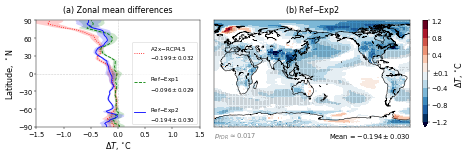

In [20]:
# Surface temperature
zonal_mean_exp2_map(variable='TS', f_or_b='b',
                    xlim=[-1.5, 1.5],
                    vlim=[-1.2, 1.2], whiteout='0.1',
                    cmap_name='RdBu_r', nlev=12,
                    mean_format='${:+.3f}\pm{:.3f}$',
                    file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

A2x-RCP4.5 mean = -11.6±1.4
Ref-Exp1 mean = -5.1±1.3
Ref-Exp2 mean = -7.1±1.3
Written local/f04.pdf


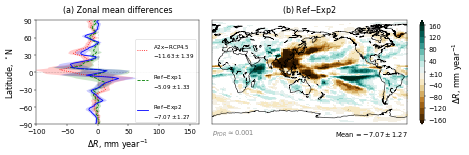

In [21]:
# Total precipitation rate
zonal_mean_exp2_map(variable='PRECC+PRECL', f_or_b='b',
                    xlim=[-100, 165],
                    vlim=[-160, 160], whiteout='10',
                    cmap_name='BrBG', nlev=16,
                    mean_format='${:+.2f}\pm{:.2f}$',
                    file_prefix='f{:02}'.format(figure_counter))
figure_counter += 1

Written local/fS05.pdf


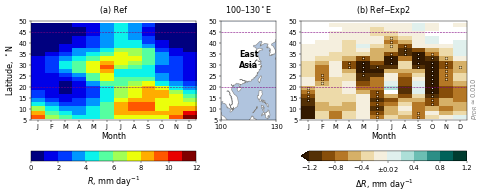

In [22]:
# Total precipitation rate over East Asia
hovmuller_ref_diff(variable='PRECC+PRECL', f_or_b='b', region='EAs',
                   ref_vlim=[0, 12], ref_whiteout='0.0',
                   ref_cmap_name='jet', ref_nlev=12,
                   diff_vlim=[-1.2, 1.2], diff_whiteout='0.02',
                   diff_cmap_name='BrBG', diff_nlev=12,
                   ylim=[5, 50],
                   file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/fS06.pdf


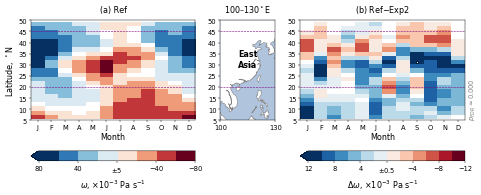

In [23]:
# Mid-tropospheric vertical motion over East Asia
hovmuller_ref_diff(variable='OMEGA_ml19', f_or_b='b', region='EAs',
                   ref_vlim=[80, -80], ref_whiteout='5',
                   ref_cmap_name='RdBu', ref_nlev=8,
                   diff_vlim=[12, -12], diff_whiteout='0.5',
                   diff_cmap_name='RdBu', diff_nlev=12,
                   ylim=[5, 50],
                   file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/fS07.pdf


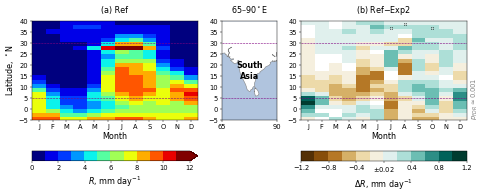

In [24]:
# Total precipitation rate over South Asia
hovmuller_ref_diff(variable='PRECC+PRECL', f_or_b='b', region='SAs',
                   ref_vlim=[0, 12], ref_whiteout='0.0',
                   ref_cmap_name='jet', ref_nlev=12,
                   diff_vlim=[-1.2, 1.2], diff_whiteout='0.02',
                   diff_cmap_name='BrBG', diff_nlev=12,
                   ylim=[-5, 40],
                   file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/fS08.pdf


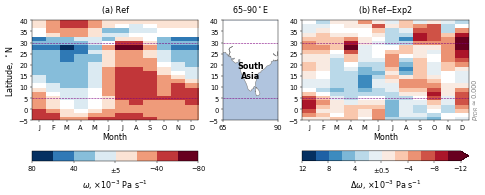

In [25]:
# Mid-tropospheric vertical motion over South Asia
hovmuller_ref_diff(variable='OMEGA_ml19', f_or_b='b', region='SAs',
                   ref_vlim=[80, -80], ref_whiteout='5',
                   ref_cmap_name='RdBu', ref_nlev=8,
                   diff_vlim=[12, -12], diff_whiteout='0.5',
                   diff_cmap_name='RdBu', diff_nlev=12,
                   ylim=[-5, 40],
                   file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/fS09.pdf


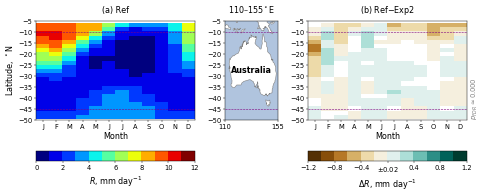

In [26]:
# Total precipitation rate over Australia
hovmuller_ref_diff(variable='PRECC+PRECL', f_or_b='b', region='Aus',
                   ref_vlim=[0, 12], ref_whiteout='0.0',
                   ref_cmap_name='jet', ref_nlev=12,
                   diff_vlim=[-1.2, 1.2], diff_whiteout='0.02',
                   diff_cmap_name='BrBG', diff_nlev=12,
                   ylim=[-50, -5],
                   file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/fS10.pdf


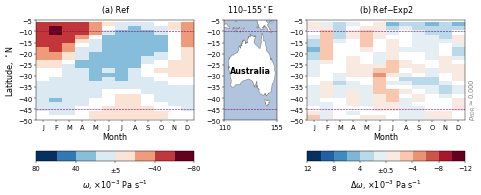

In [27]:
# Mid-tropospheric vertical motion over Australia
hovmuller_ref_diff(variable='OMEGA_ml19', f_or_b='b', region='Aus',
                   ref_vlim=[80, -80], ref_whiteout='5',
                   ref_cmap_name='RdBu', ref_nlev=8,
                   diff_vlim=[12, -12], diff_whiteout='0.5',
                   diff_cmap_name='RdBu', diff_nlev=12,
                   ylim=[-50, -5],
                   file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/fS11.pdf


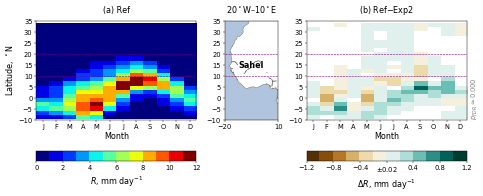

In [28]:
# Total precipitation rate over Sahel
hovmuller_ref_diff(variable='PRECC+PRECL', f_or_b='b', region='Sah',
                   ref_vlim=[0, 12], ref_whiteout='0.0',
                   ref_cmap_name='jet', ref_nlev=12,
                   diff_vlim=[-1.2, 1.2], diff_whiteout='0.02',
                   diff_cmap_name='BrBG', diff_nlev=12,
                   ylim=[-10, 35],
                   file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

Written local/fS12.pdf


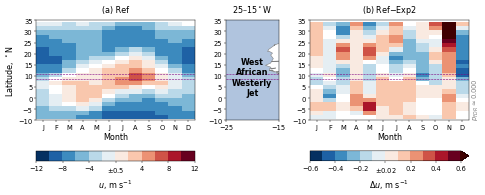

In [29]:
# West African Westerly Jet
hovmuller_ref_diff(variable='U_ml27', f_or_b='b', region='WAWJ',
                   ref_vlim=[-12, 12], ref_whiteout='0.5',
                   ref_cmap_name='RdBu_r', ref_nlev=12,
                   diff_vlim=[-0.6, 0.6], diff_whiteout='0.02',
                   diff_cmap_name='RdBu_r', diff_nlev=12,
                   ylim=[-10, 35],
                   file_prefix='fS{:02}'.format(supp_figure_counter))
supp_figure_counter += 1

In [30]:
# # High cloud fraction
# zonal_mean_exp2_map(variable='CLDHGH', f_or_b='f',
#                     xlim=[-20, 25],
#                     vlim=[-40, 40], whiteout='5',
#                     cmap_name='RdBu_r', nlev=8,
#                     mean_format='${:+.2f}\pm{:.2f}$',
#                     file_prefix='fZ{:02}'.format(other_figure_counter))
# other_figure_counter += 1

In [31]:
# # Ice water path
# zonal_mean_exp2_map(variable='TGCLDIWP', f_or_b='f',
#                     xlim=[-0.6, 1.5],
#                     vlim=[-4, 4], whiteout='0.5',
#                     cmap_name='RdBu_r', nlev=8,
#                     mean_format='${:+.3f}\pm{:.3f}$',
#                     file_prefix='fZ{:02}'.format(other_figure_counter))
# other_figure_counter += 1

In [32]:
! date

Wed Jul 18 18:49:08 +08 2018
